In [1]:
import pandas as pd
import numpy as np
import pandahouse as ph
from datetime import date
import holidays
from fbprophet import Prophet

In [2]:
# Объявляем параметры подключения к clickhouse
connection = dict(database='test',
                  host='https://clickhouse.lab.karpov.courses',
                  user='student-rw',
                  password='656e2b0c9c')

In [3]:
# Вкидываем данные (первый столбец - даты (ds), второй - уники (y))
query = """
  SELECT
    ds,
    uniqExact(DeviceID) AS y
  FROM test.installs
  WHERE Source == 'Source_27' AND Platform == 'android'
  GROUP BY CAST(InstallationDate AS Date) AS ds
  ORDER BY ds ASC
"""
df = ph.read_clickhouse(query, connection=connection)
df['ds'] = pd.to_datetime(df.ds)
df

,ds,y
0,2019-01-01,19644
1,2019-01-02,22535
2,2019-01-03,24793
3,2019-01-04,24416
4,2019-01-05,24750
...,...,...
272,2019-09-30,13986
273,2019-10-01,13976
274,2019-10-02,13830
275,2019-10-03,13453


In [4]:
# Вкидываем праздники, для их учёта моделькой
holidays_dict = holidays.RU(years=(2019, 2020, 2021))
df_holidays = pd.DataFrame.from_dict(holidays_dict, orient='index').reset_index()
df_holidays = df_holidays.rename({'index':'ds', 0:'holiday'}, axis ='columns')
df_holidays['ds'] = pd.to_datetime(df_holidays.ds)
df_holidays = df_holidays.sort_values(by=['ds'])
df_holidays = df_holidays.reset_index(drop=True)
df_holidays

,ds,holiday
0,2019-01-01,Новый год
1,2019-01-02,Новый год
2,2019-01-03,Новый год
3,2019-01-04,Новый год
4,2019-01-05,Новый год
5,2019-01-06,Новый год
6,2019-01-07,Православное Рождество
7,2019-01-08,Новый год
8,2019-02-23,День защитника отечества
9,2019-03-08,День женщин


In [5]:
# Период, который надо отрезать и предсказать (проверка модели)
predictions = 30

# Отрезаем из обучающей выборки последние N точек, чтобы измерить на них качество
train_df = df[:-predictions]

In [6]:
# Настраиваем prophet – говорим ему учитывать праздники и сезонности
m = Prophet(holidays=df_holidays, daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=False)
m.fit(train_df)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


In [7]:
# Предсказываем 30 дней
future = m.make_future_dataframe(periods=predictions)
forecast = m.predict(future)

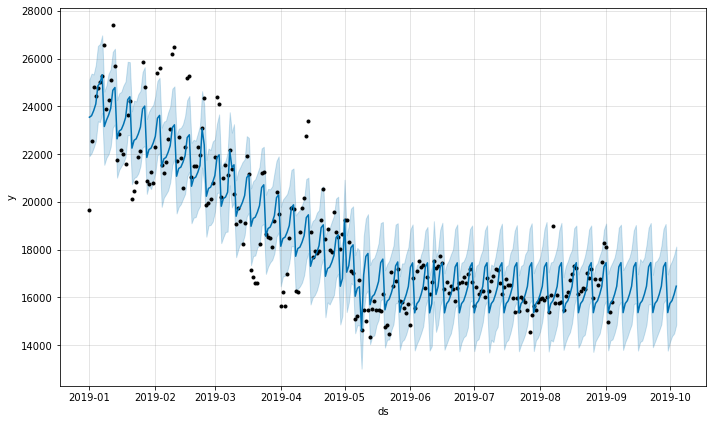

In [8]:
# Смотрим, что предсказалось
m.plot(forecast);

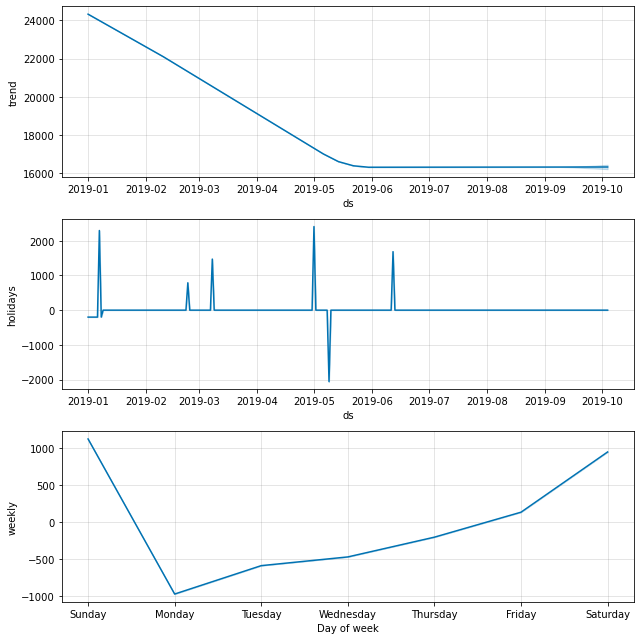

In [9]:
# Смотрим на сезонности
m.plot_components(forecast);

In [10]:
# Рисуем график с границами прогноза
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

iplot([
    go.Scatter(x=df['ds'], y=df['y'], name='fact'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='prediction'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], fill='tonexty', mode='none', name='upper'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', mode='none', name='lower'),
    go.Scatter(x=forecast['ds'], y=forecast['trend'], name='trend')
])

In [11]:
# Смотрим на ошибки модели
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100 * cmp_df['e'] / cmp_df['y']
print('MAPE (средняя абсолютная ошибка в процентах) – ', np.mean(abs(cmp_df[-predictions:]['p'])),'%')
print('MAE (средняя абсолютная ошибка) – ', np.mean(abs(cmp_df[-predictions:]['e'])))

MAPE (средняя абсолютная ошибка в процентах) –  8.965039313073595 %
MAE (средняя абсолютная ошибка) –  1312.108475251442


In [12]:
# Прогнозируем на полный период (указываем количество дней)
prediction_days = 90
final_train_df = df
f = Prophet(holidays=df_holidays, daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=False)
f.fit(final_train_df)
final_future = f.make_future_dataframe(periods=prediction_days)
final_forecast = f.predict(final_future)

In [13]:
final_forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,...,Православное Рождество,Православное Рождество_lower,Православное Рождество_upper,Праздник Весны и Труда,Праздник Весны и Труда_lower,Праздник Весны и Труда_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-01-01,24384.326909,21902.832409,25180.799021,24384.326909,24384.326909,-895.150540,-895.150540,-895.150540,-308.110746,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23489.176368
1,2019-01-02,24326.106883,22130.370726,25139.075113,24326.106883,24326.106883,-772.265392,-772.265392,-772.265392,-308.110746,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23553.841491
2,2019-01-03,24267.886858,22190.509368,25325.698268,24267.886858,24267.886858,-562.784531,-562.784531,-562.784531,-308.110746,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23705.102327
3,2019-01-04,24209.666832,22487.398125,25510.618487,24209.666832,24209.666832,-208.008359,-208.008359,-208.008359,-308.110746,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24001.658473
4,2019-01-05,24151.446807,23212.483245,26344.802497,24151.446807,24151.446807,670.291861,670.291861,670.291861,-308.110746,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24821.738668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,2019-12-29,14264.602712,13648.937132,17049.533196,13734.200406,14769.539157,1175.207849,1175.207849,1175.207849,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15439.810561
363,2019-12-30,14252.620927,11523.174481,14960.069971,13709.301473,14763.959908,-947.844618,-947.844618,-947.844618,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13304.776309
364,2019-12-31,14240.639142,11868.087262,15377.858798,13689.009852,14764.122604,-587.039794,-587.039794,-587.039794,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13653.599348
365,2020-01-01,14228.657357,11760.921234,15136.920271,13669.244309,14765.842141,-772.265392,-772.265392,-772.265392,-308.110746,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13456.391966


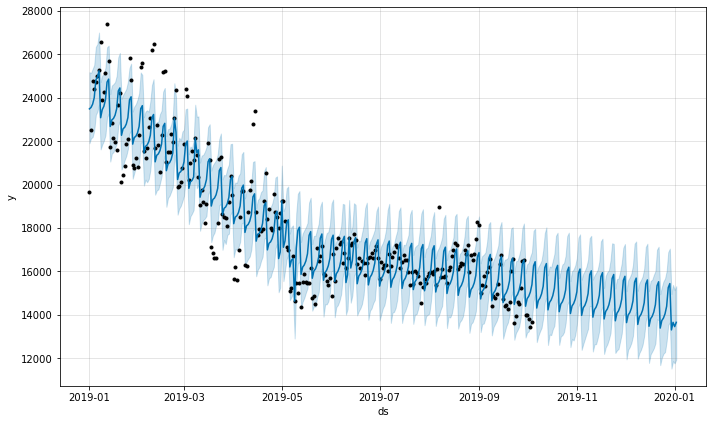

In [14]:
# Смотрим, что предсказалось на полный период
f.plot(final_forecast);

In [15]:
# Рисуем график с границами прогноза на полном периоде
iplot([
    go.Scatter(x=df['ds'], y=df['y'], name='fact'),
    go.Scatter(x=final_forecast['ds'], y=final_forecast['yhat'], name='yhat'),
    go.Scatter(x=final_forecast['ds'], y=final_forecast['yhat_upper'], fill='tonexty', mode='none', name='upper'),
    go.Scatter(x=final_forecast['ds'], y=final_forecast['yhat_lower'], fill='tonexty', mode='none', name='lower'),
    go.Scatter(x=final_forecast['ds'], y=final_forecast['trend'], name='trend')
])

In [ ]:
# Выгружаем прогноз в эксельку. Спрогнозированное значение лежит в столбце yhat
final_forecast.to_excel("./app_forecast.xlsx", sheet_name='Data', index=False, encoding="cp1251")